In [1]:
from vegetation.preprocessing.ndvi_prep import remove_ndvi_outliers,load_eumetsat_ndvi_max
import os 
import xarray as xr
from utils.function_clns import config
import logging
from dask.diagnostics import ProgressBar
import pyproj
from vegetation.preprocessing.ndvi_prep import NDVIPreprocess
import numpy as np
import matplotlib.pyplot as plt

baseline_path = config["DEFAULT"]["local"] #config["NDVI"]["ndvi_path"]

os.environ['PROJ_LIB'] = pyproj.datadir.get_data_dir()

chunks={"time":-1, "lat":"auto", "lon":"auto"}
filename = "seviri_full_image_smoothed.zarr"
ds_clean = xr.open_zarr(os.path.join(baseline_path, filename), 
                        chunks=chunks)
streaks_data = xr.open_zarr(os.path.join(
    baseline_path, 
    "mask_num_streaks.zarr"),
    chunks=chunks)

# Step 2: Calculate length of each streak
total_length = streaks_data.streaks.sum(dim='time')
num_streaks = streaks_data.streaks.count(dim='time')
days = len(streaks_data["time"])
max_strike = streaks_data.streaks.max(dim='time')

# Step 3: Calculate average
average_length = total_length / num_streaks
fraction_streaks = total_length/days

ds_clean["ndvi_clean"] = ds_clean["ndvi"].where(streaks_data.quality_flag<=45)
ds_clean["ndvi_clean"] = remove_ndvi_outliers(ds_clean["ndvi_clean"], impute=True)

filepath = os.path.join(baseline_path, "seviri_daily_ndvimax.nc")
max_ndvi = load_eumetsat_ndvi_max(filepath, 
                                  chunks=chunks)
modis_ds = xr.open_zarr(os.path.join(baseline_path, "ndvi_daily_modis.zarr"),
                        chunks= {"time":"auto", "lat":"auto", "lon":"auto"})

modis_ga = xr.open_zarr(os.path.join(baseline_path, "MOD09GA_ndvi.zarr"),
                        chunks= {"time":"auto", "lat":"auto", "lon":"auto"})

ds_ndvi = NDVIPreprocess(ds_clean["ndvi_clean"]).get_processed_data()
max_ndvi = NDVIPreprocess(max_ndvi).get_processed_data()
modis_ndvi = NDVIPreprocess(modis_ds["ndvi"]).get_processed_data()
modis_ga_ndvi = NDVIPreprocess(modis_ga["ndvi"]).get_processed_data()

### Load clouds data
def cloud_preprocess(ds):
    from utils.xarray_functions import add_time
    ds = add_time(ds)
    return ds

def load_cloud_ds(cloudfolder, parallel):
    from utils.function_clns import config
    cloud_path = os.path.join(config["NDVI"]["cloud_path"], cloudfolder)
    files = [os.path.join(cloud_path, file) for file in os.listdir(cloud_path) if file.endswith(".nc")]
    return xr.open_mfdataset(files, 
                            preprocess=cloud_preprocess, 
                            engine='netcdf4', 
                            parallel=parallel)

ds_cl = load_cloud_ds("09_15", False)
ds_cloud = NDVIPreprocess(ds_cl["cloud_mask"]).get_processed_data()

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/abc.py:85: FutureWarning: xarray subclass XarrayWS should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 70. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 70. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


[                                        ] | 0% Completed | 425.07 us

[########################################] | 100% Completed | 16.50 ss


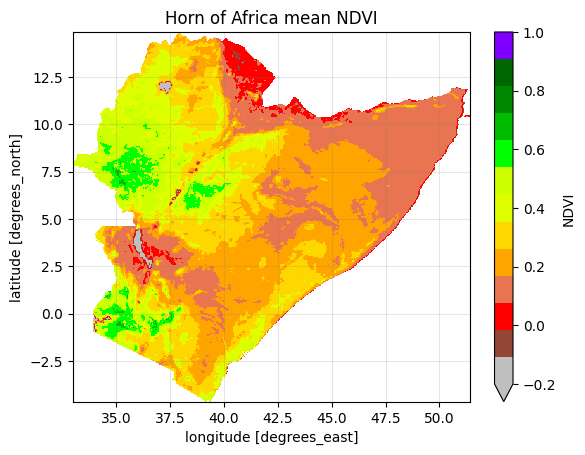

In [65]:
from utils.xarray_functions import ndvi_colormap

cmap = ndvi_colormap()

with ProgressBar():
    ds_ndvi.mean(["time"]).to_dataset(name="NDVI")["NDVI"].plot(cmap=cmap, vmin = -0.2, vmax = 1)
    plt.title("Horn of Africa mean NDVI", fontsize=12)
    plt.grid(True, color="grey", alpha=0.2)
    plt.show()

In [2]:
from utils.function_clns import prepare, align_datasets
from utils.xarray_functions import odc_reproject
import pandas as pd
from rasterio.enums import Resampling
chunks = {"time":-1, "lat":80, "lon":80}

# geobox_eumetsat = geobox_from_rio(max_ndvi)

logging.info("Starting reprojecting...")
ds_repr_eu = odc_reproject(ds_ndvi, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_eu["lat"] = max_ndvi["lat"]
ds_repr_eu["lon"] = max_ndvi["lon"]

logging.info("Succesfully reprojected our dataset")

ds_repr_mod = odc_reproject(modis_ndvi, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_mod["lat"] = max_ndvi["lat"]
ds_repr_mod["lon"] = max_ndvi["lon"]

cloud_repr = odc_reproject(ds_cloud, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

cloud_repr["lat"] = max_ndvi["lat"]
cloud_repr["lon"] = max_ndvi["lon"]


ds_repr_mod_ga = odc_reproject(modis_ga_ndvi, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_mod_ga["lat"] = max_ndvi["lat"]
ds_repr_mod_ga["lon"] = max_ndvi["lon"]

ds1, ds2, ds3, ds4 = align_datasets( ds_repr_eu,
                                    max_ndvi,
                                    ds_repr_mod,
                                    cloud_repr)

INFO:root:Starting reprojecting...
INFO:root:Succesfully reprojected our dataset


In [142]:
from ancillary.esa_landuse import get_level_1, create_copernicus_covermap
from utils.function_clns import subsetting_pipeline

cover_ds = create_copernicus_covermap(ds1)
cover_ds = subsetting_pipeline(cover_ds)
cover_ds["lat"] = ds1["lat"]
cover_ds["lon"] = ds1["lon"]
cover_ds = get_level_1(cover_ds, name="band_data").isel(band=0)

fraction_repr = prepare(fraction_streaks).rio.reproject_match(prepare(cover_ds))
green_mask = xr.where(
        cover_ds["band_data"].isin([11,12]), #   & (prepare(fraction_repr)>=0.5))
        1, 0 ).transpose("lat","lon")

forest = cover_ds["band_data"].where(
        cover_ds["band_data"].isin([11,12])).transpose("lat","lon")

water_bodies = xr.where(
        cover_ds["band_data"].isin([80]),
        1, 0 ).transpose("lat","lon")

Generating new landcover dataset
Generating URL ...
Please wait ...
Data downloaded to /media/BIFROST/N2/Riccardo/Indices_analysis/data/images/temp_cover.tif


In [ ]:
with ProgressBar():
    ds1 = ds1.load()
    ds2 = ds2.load()
    ds3 = ds3.load()
    ds4 = ds4.load()

[########################################] | 100% Completed | 13m 23s
[########################################] | 100% Completed | 27.48 ss
[########################################] | 100% Completed | 37m 26s
[########################################] | 100% Completed | 39.92 s


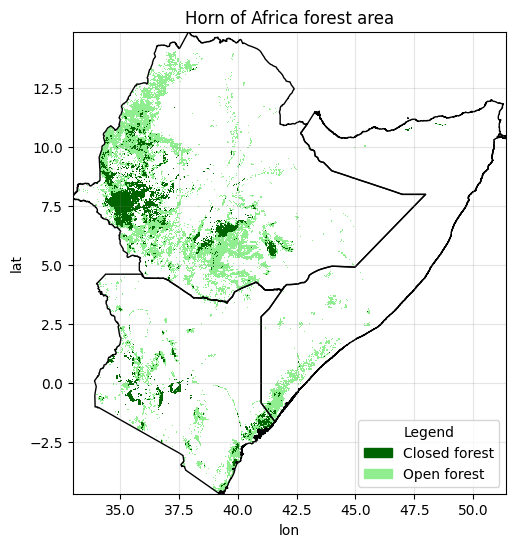

In [158]:
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

shapefile_path = config["SHAPE"]["HOA"]
gdf = gpd.read_file(shapefile_path)

# Create a custom colormap
colors = ['darkgreen', 'lightgreen']  # Colors corresponding to categories 11 and 12
cmap = mcolors.ListedColormap(colors)
bounds = [11, 12]  # Category values
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8,6))
ax = plt.gca() 

plot = forest.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
plt.title("Horn of Africa forest area", fontsize=12)

# Customize the legend
legend_labels = {11: 'Closed forest', 12: 'Open forest'}

# Create proxy artists for legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels.values())]
plt.legend(handles=patches, title='Legend',loc='lower right', bbox_to_anchor=(1, 0))

# Add the shapefile
gdf.plot(ax=ax, color='none', edgecolor='black')

plt.grid(True, color="grey", alpha=0.2)
plt.show()

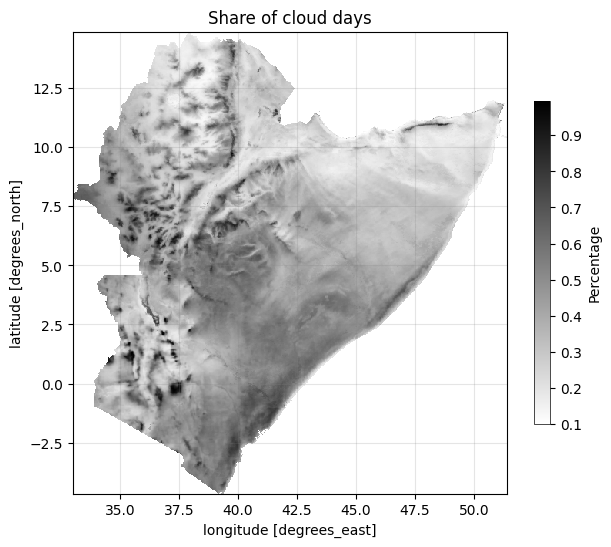

In [172]:
plt.figure(figsize=(7,6))
plot = subsetting_pipeline(fraction_streaks).plot(cmap="gist_yarg",add_colorbar=False)
plt.title("Share of cloud days", fontsize=12)
plt.grid(True, color="grey", alpha=0.2)

# Adding colorbar with a title
colorbar = plt.colorbar(plot, shrink=0.7)
colorbar.set_label('Percentage')
colorbar.set_alpha(1)  # Set transparency
colorbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
colorbar.outline.set_edgecolor('black')  # Set colorbar outline color
plt.show()

In [361]:
import xskillscore as xs

def print_metrics(corr, rmse, string1, string2):
    print(f"mean correlation between {string1} and {string2} is", corr.mean().values)
    print(f"mean rmse between {string1} and {string2} is", rmse.mean().values)
    # print(f"mean mae between {string1} and {string2} is", mae.mean().values)
    # print(f"mean mape between {string1} and {string2} is", mape.mean().values)

def compute_correpsondence_metrics(ds1, ds2):
    corr = xs.pearson_r(ds1, ds2, dim="time", skipna=True)
    rmse = xs.rmse(ds1,ds2, dim="time", skipna=True)
    return corr, rmse

In [193]:
masked_ds1 = ds1.where(water_bodies==0)
masked_ds2 = ds2.where(water_bodies==0)
masked_ds3 = ds3.where(water_bodies==0)


## Ours with EUMETSAT
with ProgressBar():
    corr_a, rmse_a = compute_correpsondence_metrics(masked_ds1, masked_ds2)
    print_metrics(corr_a, rmse_a,"OURS", "EUMETSAT")
    
    corr_b, rmse_b = compute_correpsondence_metrics(masked_ds1, masked_ds3)
    print_metrics(corr_b, rmse_b,"OURS", "MODIS")

    corr_c, rmse_c = compute_correpsondence_metrics(masked_ds2, masked_ds3)
    print_metrics(corr_c, rmse_c,"EUMETSAT", "MODIS")

mean correlation between OURS and EUMETSAT is 0.77304995
mean rmse between OURS and EUMETSAT is 0.057537742
mean correlation between OURS and MODIS is 0.34389314
mean rmse between OURS and MODIS is 0.14678152
mean correlation between EUMETSAT and MODIS is 0.49635532
mean rmse between EUMETSAT and MODIS is 0.12791604


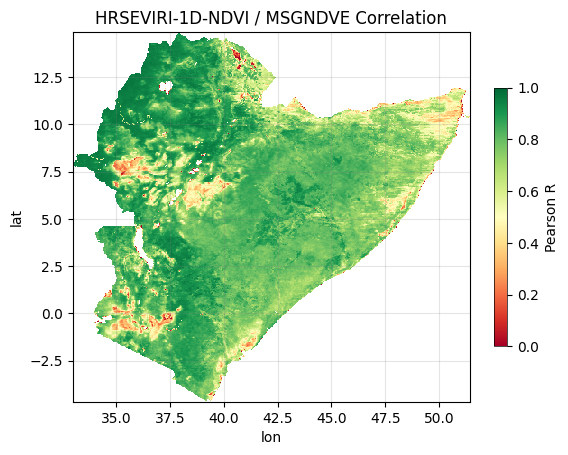

In [228]:
plot =  corr_a.plot(vmin=0, cmap="RdYlGn", add_colorbar=False)
plt.title("HRSEVIRI-1D-NDVI / MSGNDVE Correlation", fontsize=12)
plt.grid(True, color="grey", alpha=0.2)

# Adding colorbar with a title
colorbar = plt.colorbar(plot, shrink=0.7)
colorbar.set_label('Pearson R')
colorbar.set_alpha(1)  # Set transparency
colorbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
colorbar.outline.set_edgecolor('black')  # Set colorbar outline color
plt.show()

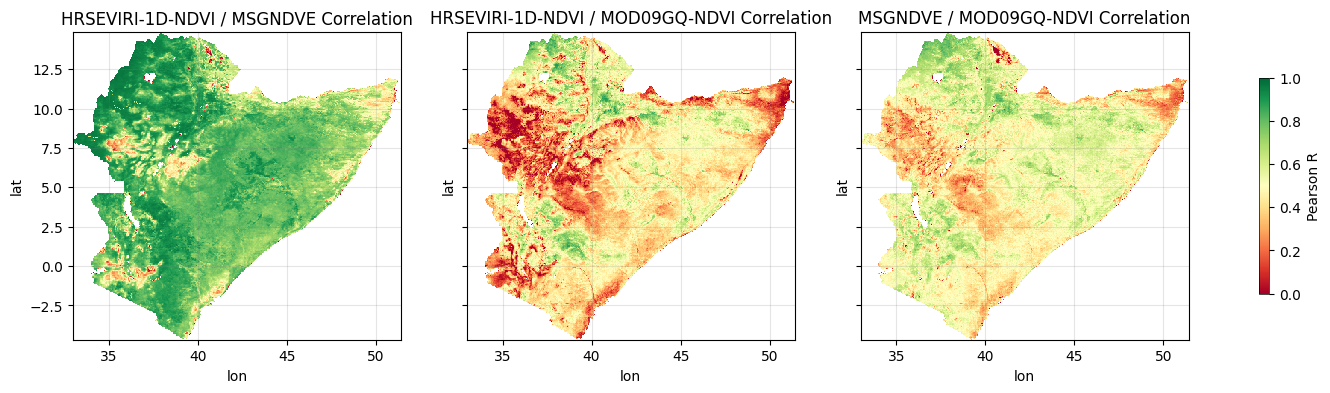

In [194]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming corr_a is a list of arrays or dataframes with data to plot
# corr_a[0] represents data for subplot 1, corr_a[1] for subplot 2, and corr_a[2] for subplot 3

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 4))  # Creating subplots
titles = ["HRSEVIRI-1D-NDVI / MSGNDVE Correlation", "HRSEVIRI-1D-NDVI / MOD09GQ-NDVI Correlation", "MSGNDVE / MOD09GQ-NDVI Correlation"]


for i, corr_data in enumerate([corr_a, corr_b, corr_c]):
    plot = corr_data.plot(ax=axs[i], vmin=0, cmap="RdYlGn", add_colorbar=False)
    axs[i].set_title(titles[i], fontsize=12)
    axs[i].grid(True, color="grey", alpha=0.2)

# Adding colorbar with a title
cbar = fig.colorbar(plot, ax=axs.ravel().tolist(), shrink=0.7)
cbar.set_label('Pearson R')
cbar.set_alpha(1)  # Set transparency
cbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
cbar.outline.set_edgecolor('black')  # Set colorbar outline color

plt.show()

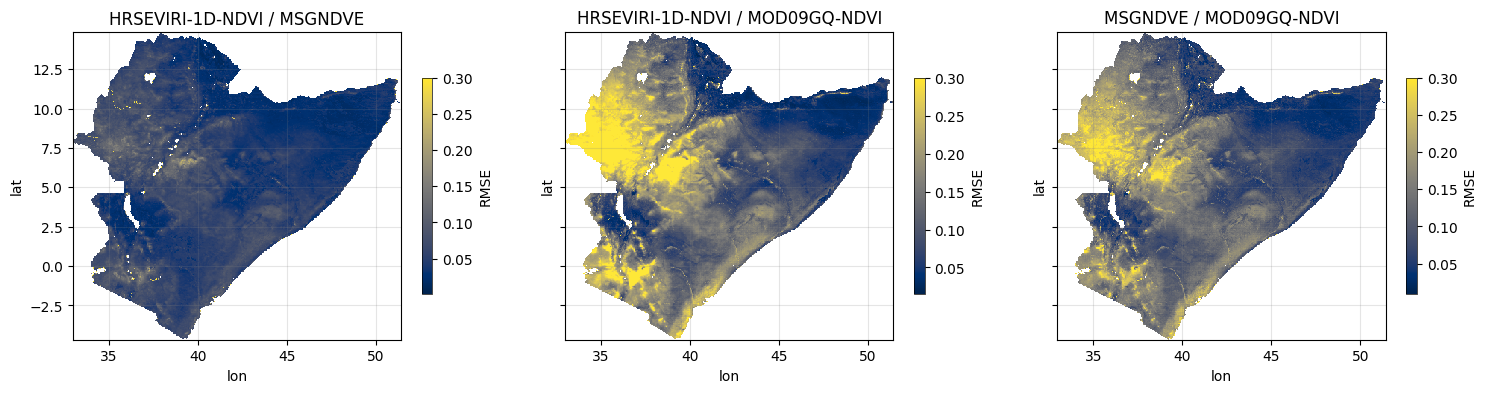

In [196]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming corr_a is a list of arrays or dataframes with data to plot
# corr_a[0] represents data for subplot 1, corr_a[1] for subplot 2, and corr_a[2] for subplot 3

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 4))  # Creating subplots
titles = ["HRSEVIRI-1D-NDVI / MSGNDVE", "HRSEVIRI-1D-NDVI / MOD09GQ-NDVI", "MSGNDVE / MOD09GQ-NDVI"]
vmax = [0.3, 0.3, 0.3]


for i, corr_data in enumerate([rmse_a, rmse_b, rmse_c]):
    plot = corr_data.plot(ax=axs[i], vmax = vmax[i], cmap="cividis", add_colorbar=False)
    axs[i].set_title(titles[i], fontsize=12)
    axs[i].grid(True, color="grey", alpha=0.2)


    # Adding colorbar with a title
    cbar = fig.colorbar(plot, ax=axs[i], shrink=0.7)
    cbar.set_label('RMSE')
    cbar.set_alpha(1)  # Set transparency
    cbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
    cbar.outline.set_edgecolor('black')  # Set colorbar outline color

plt.show()

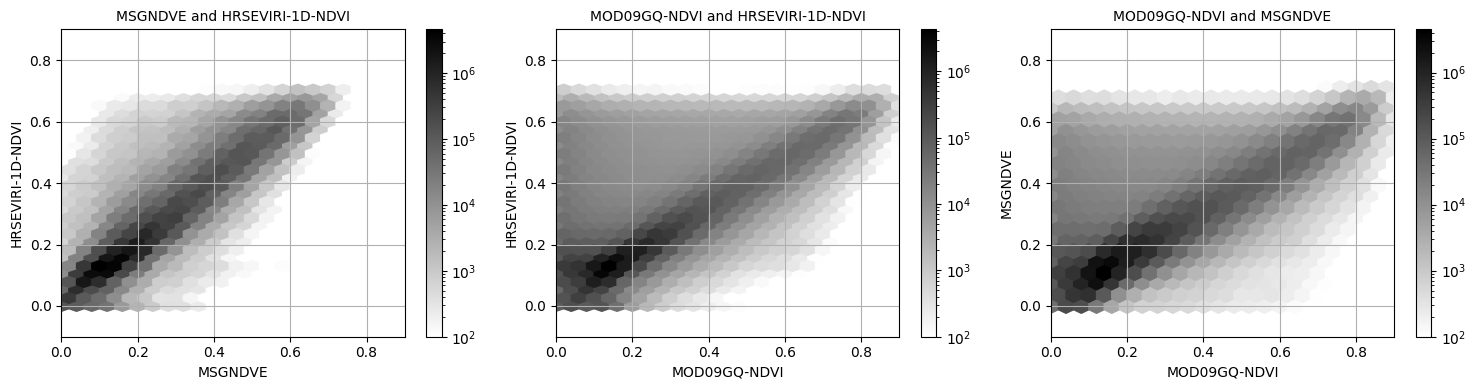

: 

In [385]:
# Extract predicted and real values
import numpy as np
from utils.xarray_functions import  set_negative_zero

mask = (water_bodies == 0) & (prepare(fraction_repr)<=0.25)


predicted_values = set_negative_zero(ds1).where(mask).values.flatten()
real_values1 = set_negative_zero(ds2).where(mask).values.flatten()
real_values2 = set_negative_zero(ds3).where(mask).values.flatten()


# arr1 = predicted_values[~np.isnan(predicted_values)]
# arr2 = real_values[~np.isnan(real_values)]

datasets = [predicted_values, real_values1, real_values2]
pairs = [(1, 0), (2, 0), (2, 1)]
titles = ['HRSEVIRI-1D-NDVI', 'MSGNDVE','MOD09GQ-NDVI' ] 
colors = ["Blues", "Greens", "Oranges"]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # Creating subplots

for i, (idx1, idx2) in enumerate(pairs):
    hb = axs[i].hexbin(datasets[idx1], datasets[idx2], gridsize=25, vmin=100, bins='log', cmap="gist_yarg")
    axs[i].set_title(f"{titles[idx1]} and {titles[idx2]}", fontsize=10)
    axs[i].set_xlabel(f'{titles[idx1]}')
    axs[i].set_xlim(0, 0.9)
    axs[i].set_ylim(-0.1, 0.9)
    axs[i].set_ylabel(f'{titles[idx2]}')
    axs[i].grid(True)
    plt.colorbar(hb, ax=axs[i])

plt.tight_layout()
plt.show()

### MAD

In [211]:
from vegetation import abs_diff, abs_mape

diff_1 = abs_diff(ds1.where(water_bodies==0)).where(prepare(fraction_repr)<=0.25)
diff_2 = abs_diff(ds2.where(water_bodies==0)).where(prepare(fraction_repr)<=0.25)
diff_3 = abs_diff(ds3.where(water_bodies==0)).where(prepare(fraction_repr)<=0.25)

print("MAD:")
print(diff_1.mean().values)
print(diff_2.mean().values)
print(diff_3.mean().values)

print("MAD forest:")
print(diff_1.where(green_mask==1).mean().values)
print(diff_2.where(green_mask==1).mean().values)
print(diff_3.where(green_mask==1).mean().values)

MAD:
0.0010527279
0.0176033
0.053572513
MAD forest:
0.0022552428
0.03175075
0.13086936


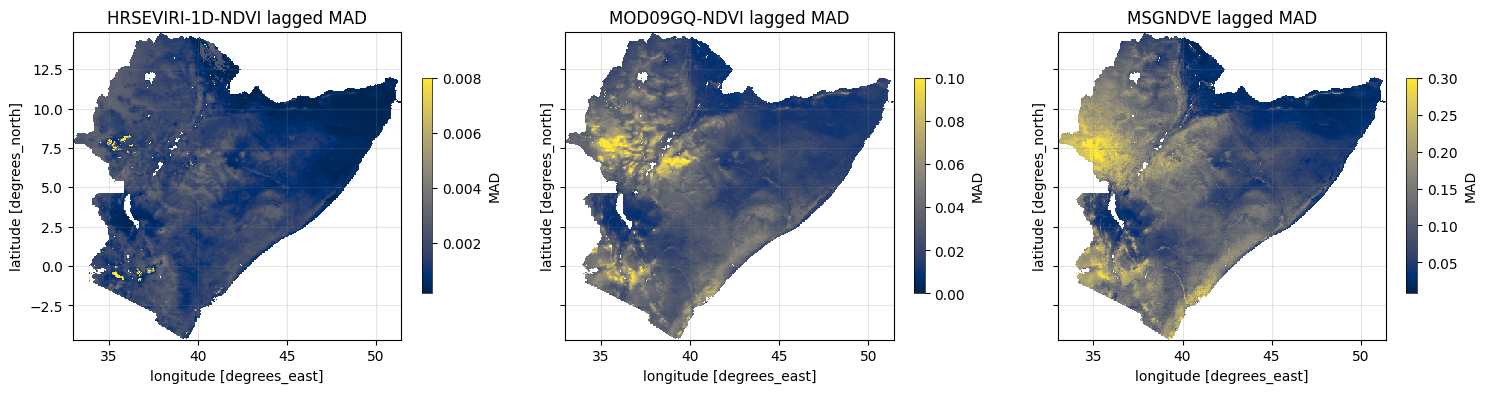

In [201]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming corr_a is a list of arrays or dataframes with data to plot
# corr_a[0] represents data for subplot 1, corr_a[1] for subplot 2, and corr_a[2] for subplot 3

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 4))  # Creating subplots
titles = ["HRSEVIRI-1D-NDVI", "MOD09GQ-NDVI", "MSGNDVE"]
vmax = [0.008, 0.1, 0.3]

for i, corr_data in enumerate([diff_1, diff_2, diff_3]):
    plot = corr_data.mean(["time"]).plot(ax=axs[i],vmax=vmax[i], cmap="cividis", add_colorbar=False)
    axs[i].set_title(f"{titles[i]} lagged MAD", fontsize=12)
    axs[i].grid(True, color="grey", alpha=0.2)


    # Adding colorbar with a title
    cbar = fig.colorbar(plot, ax=axs[i], shrink=0.7)
    cbar.set_label('MAD')
    cbar.set_alpha(1)  # Set transparency
    cbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
    cbar.outline.set_edgecolor('black')  # Set colorbar outline color

plt.show()

## NDVI 10 days

In [3]:
import xarray as xr 
import os
from vegetation.preprocessing.ndvi_prep import load_landsaf_ndvi
from utils.xarray_functions import dataset_to_dekad, odc_reproject, set_negative_zero
from utils.function_clns import align_datasets

path = "/media/BIFROST/N2/Riccardo/output"
target_store = "output_file.zarr"
zarr_path = os.path.join(path, target_store)
ds_lsaf = load_landsaf_ndvi(zarr_path)

ds_ndvi10 = dataset_to_dekad(ds_ndvi)
ds_mod10 = dataset_to_dekad(modis_ndvi)

logging.info("Starting reprojecting...")
ds_repr_eu10 = odc_reproject(ds_ndvi10, ds_lsaf, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_eu10["lat"] = ds_lsaf["lat"]
ds_repr_eu10["lon"] = ds_lsaf["lon"]

logging.info("Succesfully reprojected our dataset")

ds_repr_mod10 = odc_reproject(ds_mod10, ds_lsaf, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_mod10["lat"] = ds_lsaf["lat"]
ds_repr_mod10["lon"] = ds_lsaf["lon"]

ds5, ds6, ds7, _ = align_datasets(ds_repr_eu10, ds_lsaf, ds_repr_mod10)

with ProgressBar():
    ds5 = ds5.load()
    ds6 = ds6.load()
    ds7 = ds7.load()

INFO:root:Starting reprojecting...
INFO:root:Succesfully reprojected our dataset


[#                                       ] | 3% Completed | 54.73 sms

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


[########################################] | 100% Completed | 10m 57s
[########################################] | 100% Completed | 7.84 sms
[########################################] | 100% Completed | 63m 45s


In [254]:
from ancillary.esa_landuse import get_level_1
from utils.function_clns import subsetting_pipeline, prepare
from ancillary.esa_landuse import create_copernicus_covermap

cover_ds = create_copernicus_covermap(prepare(ds6))
cover_ds = subsetting_pipeline(cover_ds)
cover_ds["lat"] = ds6["lat"]
cover_ds["lon"] = ds6["lon"]
cover_ds = get_level_1(cover_ds.isel(band=0).band_data, name="band_data")

fraction_repr = prepare(fraction_streaks).rio.reproject_match(prepare(cover_ds))
green_mask = xr.where(
        cover_ds["band_data"].isin([11,12]), #   & (prepare(fraction_repr)>=0.5))
        1, 0 ).transpose("lat","lon")

water_bodies = xr.where(
        cover_ds["band_data"].isin([80]),
        1, 0 ).transpose("lat","lon")

Generating new landcover dataset
Generating URL ...
Please wait ...
Data downloaded to /media/BIFROST/N2/Riccardo/Indices_analysis/data/images/temp_cover.tif


In [306]:
from sklearn.linear_model import LinearRegression

mask = (water_bodies == 0) & (prepare(fraction_repr)<=0.25)

df_1 = set_negative_zero(ds5).where(mask).to_dataframe(name="ndvi_msg").dropna(subset="ndvi_msg")["ndvi_msg"]
df_2 = set_negative_zero(ds7).where(mask).to_dataframe(name="ndvi_modis").dropna(subset="ndvi_modis")["ndvi_modis"]
df_new = pd.merge(df_1, df_2, left_index=True, right_index=True, how="inner")

X = df_new["ndvi_msg"].values.reshape(-1, 1) 
y = df_new["ndvi_modis"].values
model = LinearRegression().fit(X, y)

print(model.coef_)
print(model.score(X, y))
print(model.intercept_)

msg_corr = ds5 * model.coef_[0] + model.intercept_

[1.256689]
0.900306349011679
0.015705526


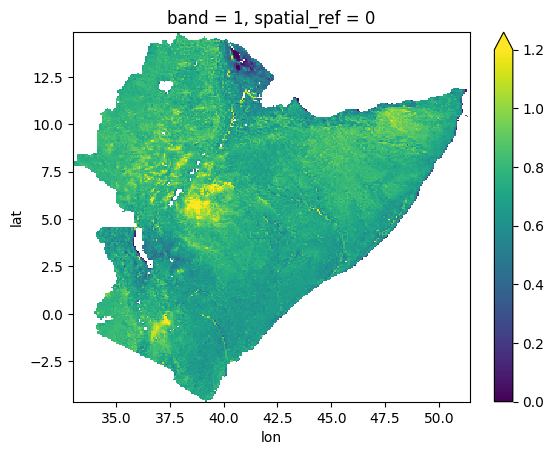

In [325]:
mask = (water_bodies == 0)
bias_ds = set_negative_zero(ds5.where(mask))/set_negative_zero(ds7.where(mask))
bias_ds.mean(["time"]).plot(vmax=1.2)

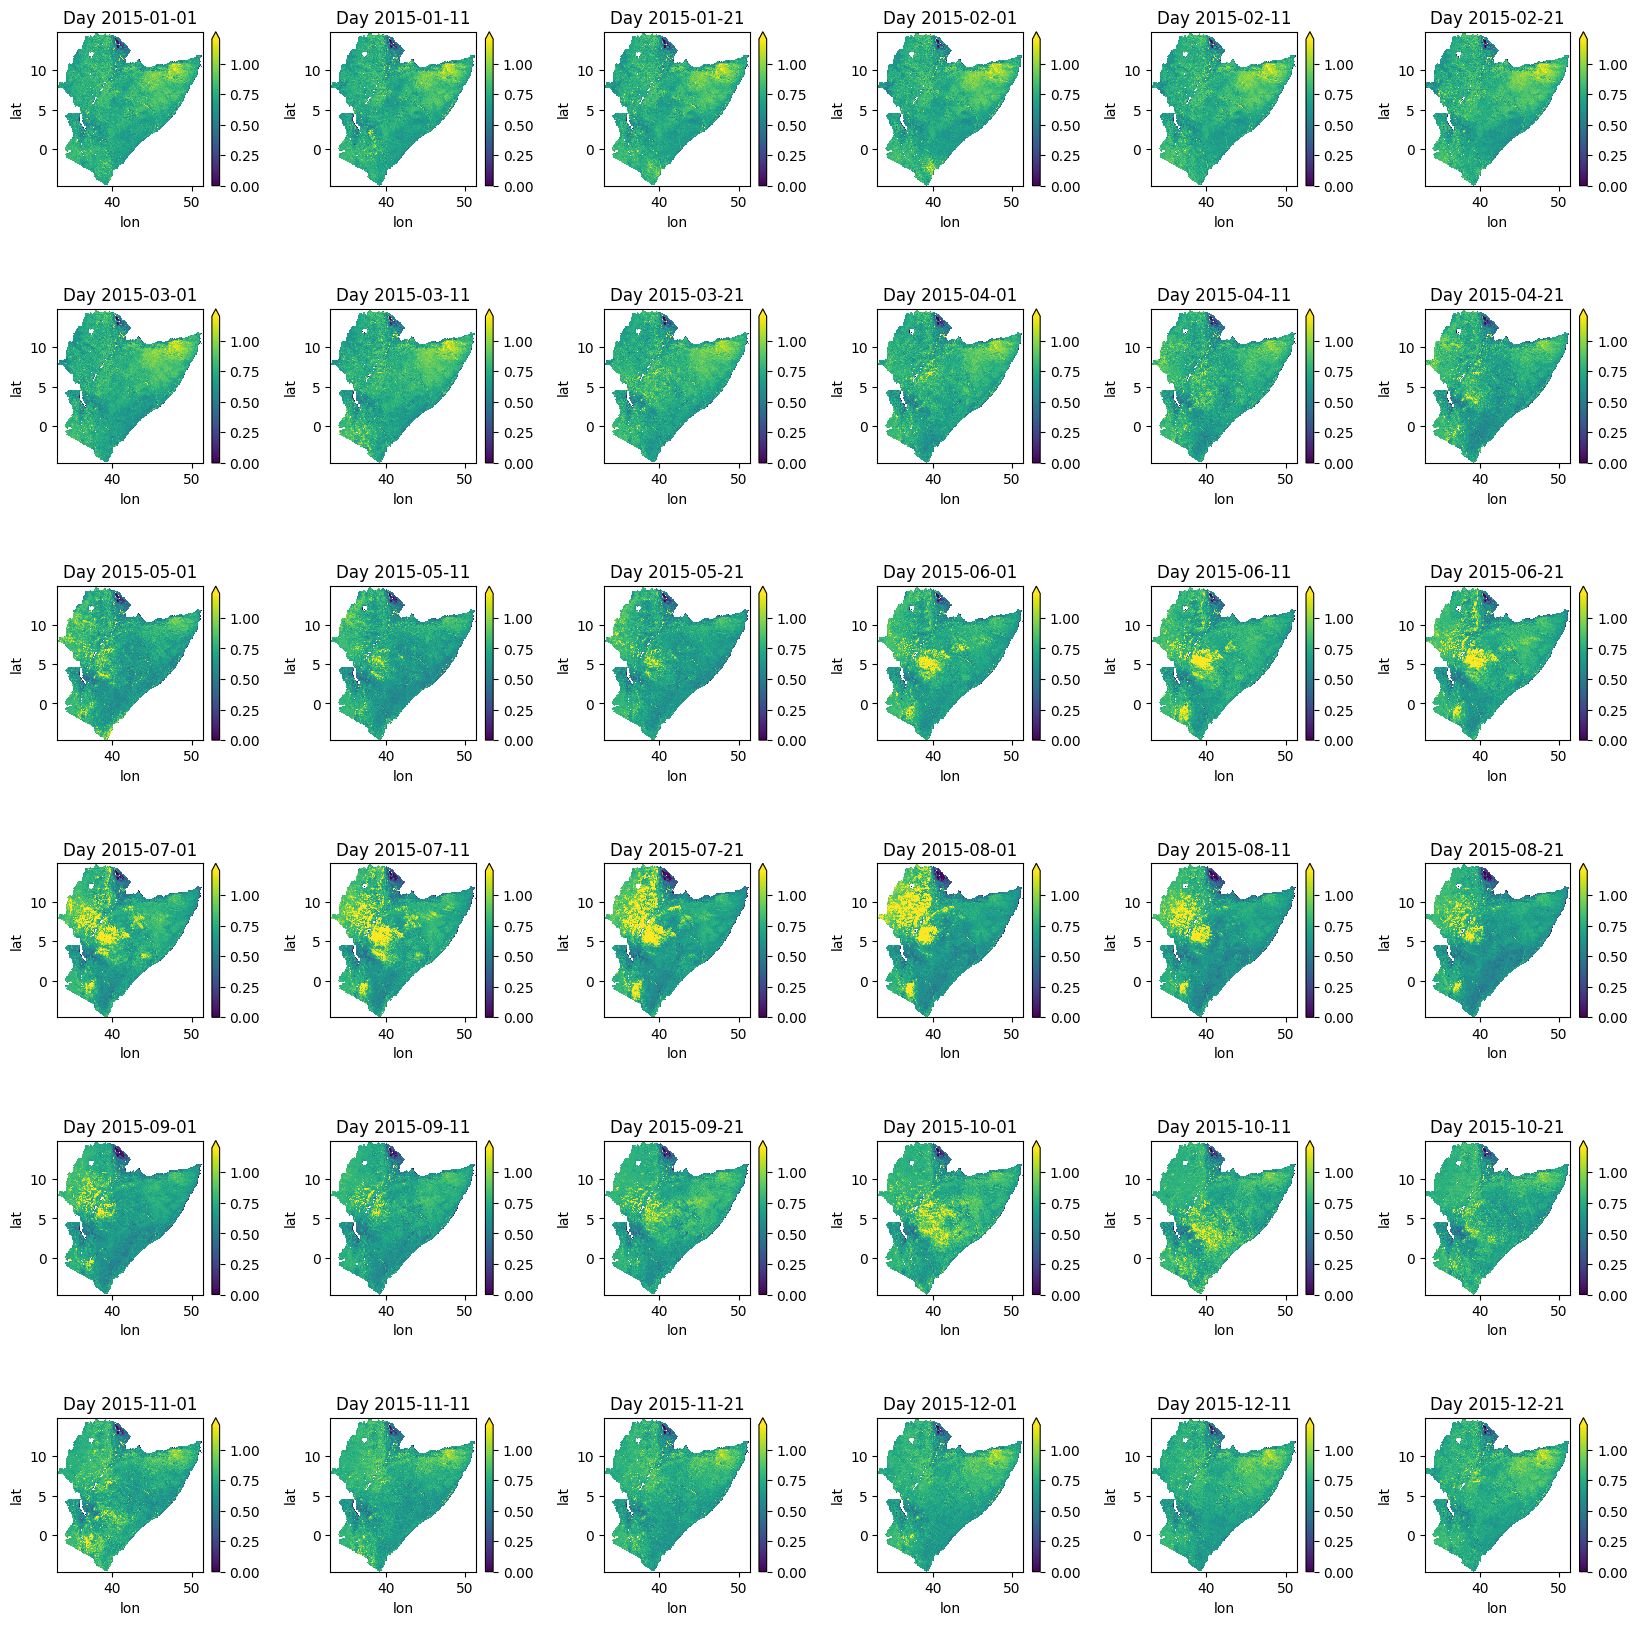

In [359]:
from datetime import datetime, timedelta

data_array = bias_ds.convert_calendar("noleap")\
    .groupby("time.dayofyear").mean(["time"]).transpose("dayofyear","lat","lon")
fig, axes = plt.subplots(6, 6, figsize=(20,20))
axes = axes.flatten()

def day_of_year_to_date(day_of_year, year=2015):
    result_date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
    return  result_date.strftime("%Y-%m-%d")

vmin = 0
vmax = 1.2

# Loop through each observation
for i, ds in enumerate(data_array):
    ax = axes[i]
        # ndvi.plot(ax=ax, cmap=cmap_custom)
    ds.plot(ax = ax, vmin=vmin, vmax=vmax)
    # Add title
    ax.set_title(f'Day {day_of_year_to_date(int(ds.dayofyear.values))}')

plt.subplots_adjust(hspace=0.8, wspace = 0.5)  
# Show plot
plt.show()

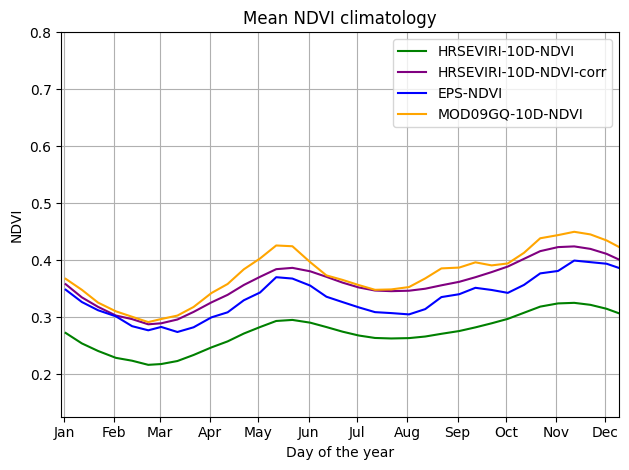

In [309]:
import matplotlib.dates as mdates

ds5.where(water_bodies==0).convert_calendar("noleap").groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="green", label="HRSEVIRI-10D-NDVI")
msg_corr.where(water_bodies==0).convert_calendar("noleap").groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="purple", label="HRSEVIRI-10D-NDVI-corr")
ds6.ndvi_10.where(water_bodies==0).convert_calendar("noleap").groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="blue", label= "EPS-NDVI")
ds7.where(water_bodies==0).convert_calendar("noleap").groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="orange", label="MOD09GQ-10D-NDVI")

# Formatting x-axis ticks to show month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Abbreviated month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Get current x-axis limits
x_min, x_max = plt.xlim()

# Extend the x-axis limits to skip the last label
plt.xlim(x_min+15, x_max - 30)  # Skip the last 30 days
plt.ylim(0.125, 0.8)

plt.title('Mean NDVI climatology')
plt.legend()
plt.ylabel("NDVI")
plt.xlabel("Day of the year")
plt.grid(True)
plt.tight_layout()
plt.show()

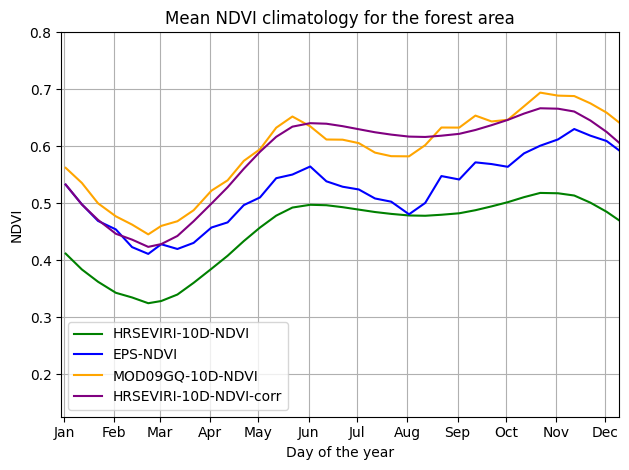

In [310]:
import matplotlib.dates as mdates

ds5.where(water_bodies==0).where(green_mask==1).convert_calendar("noleap").groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="green", label="HRSEVIRI-10D-NDVI")
ds6.ndvi_10.where(water_bodies==0).convert_calendar("noleap").where(green_mask==1).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="blue", label= "EPS-NDVI")
ds7.where(water_bodies==0).convert_calendar("noleap").where(green_mask==1).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="orange", label="MOD09GQ-10D-NDVI")
msg_corr.where(water_bodies==0).where(green_mask==1).convert_calendar("noleap").groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="purple", label="HRSEVIRI-10D-NDVI-corr")

# Formatting x-axis ticks to show month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Abbreviated month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Get current x-axis limits
x_min, x_max = plt.xlim()

# Extend the x-axis limits to skip the last label
plt.xlim(x_min+15, x_max - 30)  # Skip the last 30 days
plt.ylim(0.125, 0.8)

plt.title('Mean NDVI climatology for the forest area')
plt.legend()
plt.ylabel("NDVI")
plt.xlabel("Day of the year")
plt.grid(True)
plt.tight_layout()
plt.show()

In [366]:
mask = (water_bodies == 0) 


masked_ds5 = ds5.where(mask)
masked_ds6 = ds6.ndvi_10.where(mask)
masked_ds7 = ds7.where(mask)
msked_corr = msg_corr.where(mask)


## Ours with EUMETSAT
with ProgressBar():
    corr_d, rmse_d = compute_correpsondence_metrics(masked_ds5, masked_ds6)
    print_metrics(corr_d, rmse_d,"OURS", "LSAF")
    
    corr_e, rmse_e = compute_correpsondence_metrics(masked_ds5, masked_ds7)
    print_metrics(corr_e, rmse_e, "OURS", "MODIS")

    corr_f, rmse_f = compute_correpsondence_metrics(masked_ds6, masked_ds7)
    print_metrics(corr_f, rmse_f,"LSAF", "MODIS")

    corr_g, rmse_g = compute_correpsondence_metrics(msked_corr, masked_ds7)
    print_metrics(corr_g, rmse_g, "OURS_CORR", "MODIS")

mean correlation between OURS and LSAF is 0.63987523
mean rmse between OURS and LSAF is 0.10389459
mean correlation between OURS and MODIS is 0.7556979
mean rmse between OURS and MODIS is 0.12562068
mean correlation between LSAF and MODIS is 0.6773018
mean rmse between LSAF and MODIS is 0.09823969
mean correlation between OURS_CORR and MODIS is 0.7556979
mean rmse between OURS_CORR and MODIS is 0.07872974


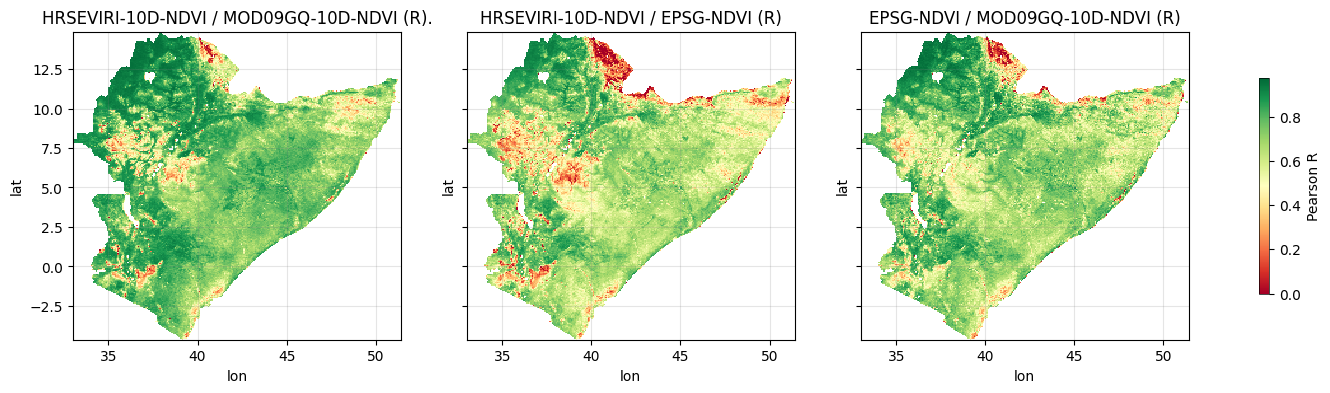

In [368]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming corr_a is a list of arrays or dataframes with data to plot
# corr_a[0] represents data for subplot 1, corr_a[1] for subplot 2, and corr_a[2] for subplot 3

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 4))  # Creating subplots
titles = ["HRSEVIRI-10D-NDVI / MOD09GQ-10D-NDVI (R).", "HRSEVIRI-10D-NDVI / EPSG-NDVI (R)", "EPSG-NDVI / MOD09GQ-10D-NDVI (R)"]


for i, corr_data in enumerate([corr_e, corr_d, corr_f]):
    plot = corr_data.plot(ax=axs[i], vmin=0, cmap="RdYlGn", add_colorbar=False)
    axs[i].set_title(titles[i], fontsize=12)
    axs[i].grid(True, color="grey", alpha=0.2)

# Adding colorbar with a title
cbar = fig.colorbar(plot, ax=axs.ravel().tolist(), shrink=0.7)
cbar.set_label('Pearson R')
cbar.set_alpha(1)  # Set transparency
cbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
cbar.outline.set_edgecolor('black')  # Set colorbar outline color

plt.show()

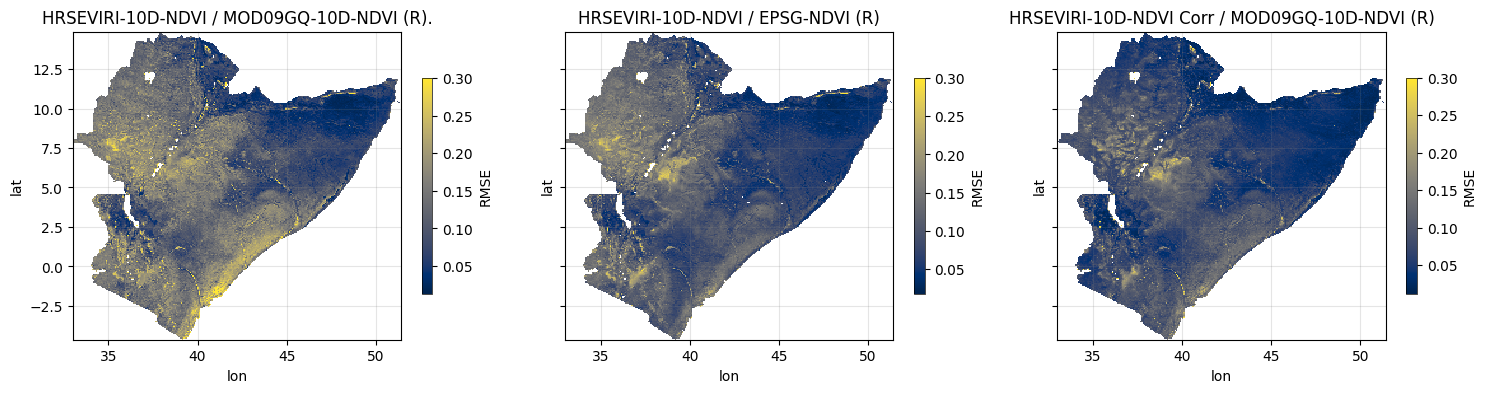

In [369]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming corr_a is a list of arrays or dataframes with data to plot
# corr_a[0] represents data for subplot 1, corr_a[1] for subplot 2, and corr_a[2] for subplot 3

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 4))  # Creating subplots
titles = ["HRSEVIRI-10D-NDVI / MOD09GQ-10D-NDVI (R).", "HRSEVIRI-10D-NDVI / EPSG-NDVI (R)", "HRSEVIRI-10D-NDVI Corr / MOD09GQ-10D-NDVI (R)"]
vmax = [0.3, 0.3, 0.3]


for i, corr_data in enumerate([rmse_e, rmse_d, rmse_g]):
    plot = corr_data.plot(ax=axs[i], vmax = vmax[i], cmap="cividis", add_colorbar=False)
    axs[i].set_title(titles[i], fontsize=12)
    axs[i].grid(True, color="grey", alpha=0.2)


    # Adding colorbar with a title
    cbar = fig.colorbar(plot, ax=axs[i], shrink=0.7)
    cbar.set_label('RMSE')
    cbar.set_alpha(1)  # Set transparency
    cbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
    cbar.outline.set_edgecolor('black')  # Set colorbar outline color

plt.show()

### MAD

In [100]:
from vegetation.analysis.indices import abs_diff

diff_5 = abs_diff(masked_ds5)
diff_6 = abs_diff(masked_ds6)
diff_7 = abs_diff(masked_ds7)

print("MAD:")
print(diff_5.mean().values)
print(diff_6.mean().values)
print(diff_7.mean().values)

print("MAD forest:")
print(diff_5.where(green_mask==1).mean().values)
print(diff_6.where(green_mask==1).mean().values)
print(diff_7.where(green_mask==1).mean().values)

MAD:
0.015184657
0.064586334
0.053984415
MAD forest:
0.022266049
0.112704575
0.08606777


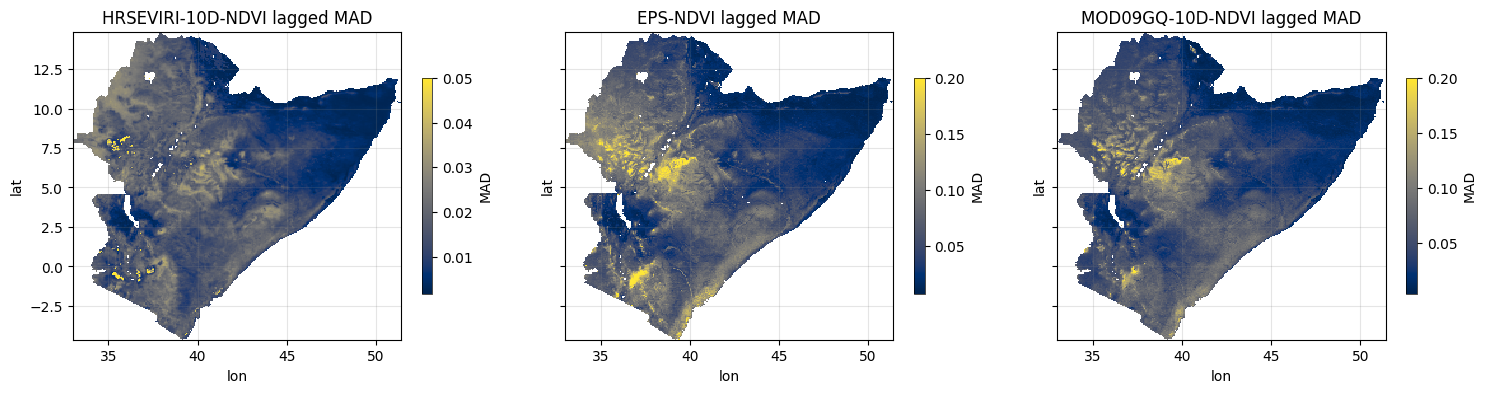

In [228]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming corr_a is a list of arrays or dataframes with data to plot
# corr_a[0] represents data for subplot 1, corr_a[1] for subplot 2, and corr_a[2] for subplot 3

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 4))  # Creating subplots
titles = ['HRSEVIRI-10D-NDVI', 'EPS-NDVI','MOD09GQ-10D-NDVI' ]
vmax = [0.05, 0.2, 0.2]

for i, corr_data in enumerate([diff_5, diff_6, diff_7]):
    plot = corr_data.mean(["time"]).plot(ax=axs[i],vmax=vmax[i], cmap="cividis", add_colorbar=False)
    axs[i].set_title(f"{titles[i]} lagged MAD", fontsize=12)
    axs[i].grid(True, color="grey", alpha=0.2)


    # Adding colorbar with a title
    cbar = fig.colorbar(plot, ax=axs[i], shrink=0.7)
    cbar.set_label('MAD')
    cbar.set_alpha(1)  # Set transparency
    cbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
    cbar.outline.set_edgecolor('black')  # Set colorbar outline color

plt.show()

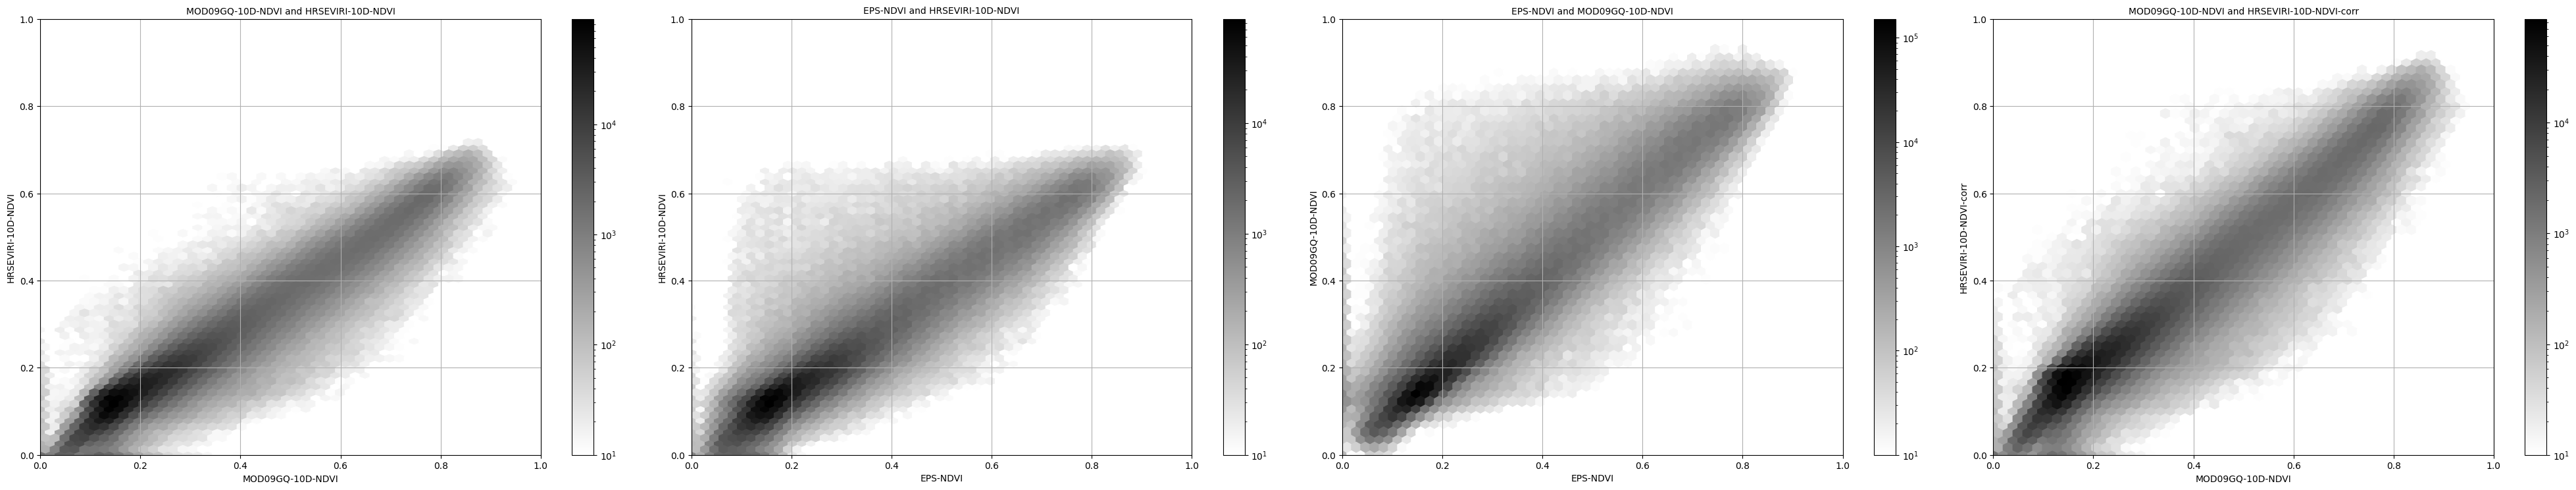

In [380]:
from utils.xarray_functions import set_negative_zero
# Extract predicted and real values
mask = (water_bodies == 0) & (prepare(fraction_repr) < 0.25)

predicted_values = set_negative_zero(ds5).where(mask).values.flatten()
real_values1 = set_negative_zero(ds6.ndvi_10).where(mask).values.flatten()
real_values2 = set_negative_zero(ds7).where(mask).values.flatten()
real_values3 = set_negative_zero(msg_corr).where(mask).values.flatten() 

# arr1 = predicted_values[~np.isnan(predicted_values)]
# arr2 = real_values[~np.isnan(real_values)]

datasets = [predicted_values, real_values1, real_values2, real_values3]
pairs = [(2, 0), (1, 0), (1, 2), (2, 3)]
titles = ['HRSEVIRI-10D-NDVI', 'EPS-NDVI','MOD09GQ-10D-NDVI', 'HRSEVIRI-10D-NDVI-corr' ] 
colors = ["Blues", "Greens", "Oranges"]

fig, axs = plt.subplots(1, 4, figsize=(40, 10))  # Creating subplots


for i, (idx1, idx2) in enumerate(pairs):
    hb = axs[i].hexbin(datasets[idx1], datasets[idx2], gridsize=50, vmin = 10, bins='log', cmap="gist_yarg")
    axs[i].set_title(f"{titles[idx1]} and {titles[idx2]}", fontsize=10)
    axs[i].set_xlabel(f'{titles[idx1]}')
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].set_ylabel(f'{titles[idx2]}')
    axs[i].grid(True)
    plt.colorbar(hb, ax=axs[i])

plt.tight_layout()
plt.subplots_adjust(top=0.72) 
plt.show()

# Autocorrelation

In [ ]:
from vegetation.analysis.indices import autocorr
import matplotlib.pyplot as plt

lags = 30

lead_cunk = {"lat":"auto", "lon":"auto", "lead":"auto"}
auto_ds1 = autocorr(ds1.chunk(chunks), nlags=lags, skipna=True)
auto_ds2 = autocorr(ds2.chunk(chunks), nlags=lags, skipna=True)
auto_ds3 = autocorr(ds3.chunk(chunks), nlags=lags, skipna=True)

with ProgressBar():
    auto_mean_3 = auto_ds3.mean(["lat","lon"])
    auto_mean_1 = auto_ds1.mean(["lat","lon"])
    auto_mean_2 = auto_ds2.mean(["lat","lon"])
    auto_mean_3 = auto_mean_3.load()
    auto_mean_2 = auto_mean_2.load()
    auto_mean_1 = auto_mean_1.load()

In [ ]:
from vegetation.analysis.indices import autocorr
lags = 7
auto_ds6 = autocorr(ds6.chunk(chunks), nlags=lags, skipna=True)
auto_mean_6 = auto_ds6.mean(["lat","lon"])
df6 = auto_mean_6.to_dataframe()["ndvi_10"]


auto_ds7 = autocorr(ds7.chunk(chunks), nlags=lags, skipna=True)
auto_mean_7 = auto_ds7.mean(["lat","lon"])
df7 = auto_mean_7.to_dataframe(name="ndvi_10")["ndvi_10"]

auto_ds5 = autocorr(ds5.chunk(chunks), nlags=lags, skipna=True)
auto_mean_5 = auto_ds5.mean(["lat","lon"])
df5 = auto_mean_5.to_dataframe(name="ndvi_10")["ndvi_10"]


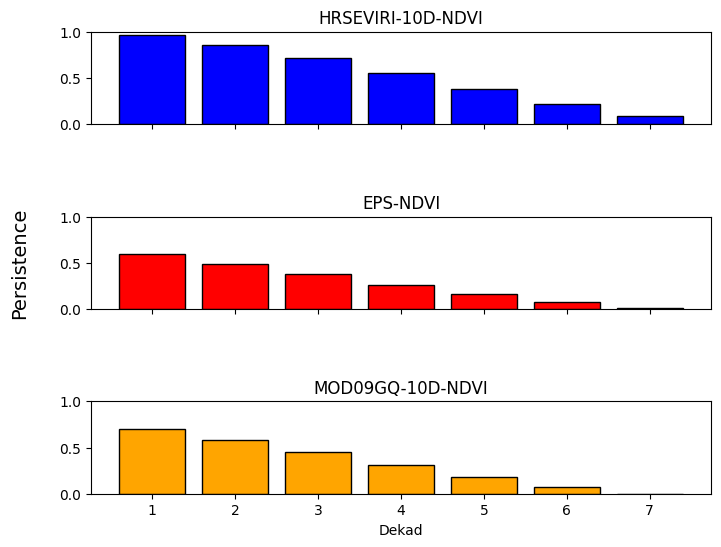

In [215]:
import matplotlib.pyplot as plt

# Assuming df1, df2, and df3 are your DataFrames
fig, axes = plt.subplots(3, 1, 
                         figsize=(8, 6), 
                         sharex=True)  # Create subplots with shared x-axis

# Plot each DataFrame in a separate subplot
axes[0].bar(df5.index + 1, df5, edgecolor='black', color="blue")
axes[1].bar(df6.index + 1, df6, edgecolor='black', color="red")
# axes[2].bar(df3.index + 1, df3, edgecolor='black', color="orange")
axes[2].bar(df7.index + 1, df7, edgecolor='black', color="orange")


axes[0].set_title("HRSEVIRI-10D-NDVI")
axes[1].set_title("EPS-NDVI")
axes[2].set_title("MOD09GQ-10D-NDVI")
# axes[3].set_title("MOD09GA-NDVI")

# Set labels and title

plt.xlabel('Dekad')
axes[1].set_ylabel('Persistence', fontsize=14)
axes[1].yaxis.set_label_coords(-0.1, 0.5)

for ax in [axes[0], axes[1], axes[2]]:
     ax.set_ylim(0, 1)

# Adjust space between subplots
plt.subplots_adjust(hspace=1)

# Adjust space between main title and subplot titles
# fig.suptitle('Autocorrelation', y=0.95, fontsize=16)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

df3 = auto_mean_3.to_dataframe(name="ndvi")["ndvi"]
df2 = auto_mean_2.to_dataframe(name="ndvi")["ndvi"]
df1 = auto_mean_1.to_dataframe(name="ndvi")["ndvi"]

# Assuming df1, df2, and df3 are your DataFrames
fig, axes = plt.subplots(3, 1, 
                         figsize=(8, 6), 
                         sharex=True)  # Create subplots with shared x-axis

# Plot each DataFrame in a separate subplot
axes[0].bar(df3.index + 1, df3, edgecolor='black', color="blue")
axes[1].bar(df2.index + 1, df2, edgecolor='black', color="red")
# axes[2].bar(df3.index + 1, df3, edgecolor='black', color="orange")
axes[2].bar(df1.index + 1, df1, edgecolor='black', color="orange")


axes[0].set_title("HRSEVIRI-1D-NDVI")
axes[1].set_title("MSGNDVE")
axes[2].set_title("MOD09GQ-NDVI")
# axes[3].set_title("MOD09GA-NDVI")

# Set labels and title

plt.xlabel('Days')
axes[1].set_ylabel('Persistence', fontsize=14)
axes[1].yaxis.set_label_coords(-0.1, 0.5)

for ax in [axes[0], axes[1]]:
    ax.set_ylim(0, 1)

# Adjust space between subplots
plt.subplots_adjust(hspace=1)

# Adjust space between main title and subplot titles
# fig.suptitle('Autocorrelation', y=0.95, fontsize=16)

plt.show()

## Plotting points

In [ ]:
from analysis.visualizations.viz_series import plot_random_masked_over_time, select_random_points
import matplotlib.pyplot as plt

start_date = "2017-01-01"
end_date = "2019-01-01"
n= 5


valid_indices, random_indices = select_random_points(green_mask, 
                                                     n_points = n)

plot_random_masked_over_time(ds1, valid_indices, 
                             random_indices, start_date, end_date)

plot_random_masked_over_time(ds2, valid_indices, random_indices, start_date, end_date)

plot_random_masked_over_time(ds3, valid_indices, random_indices, start_date, end_date)

# random_indices = [ 8289, 10619, 12757, 13611, 13922]

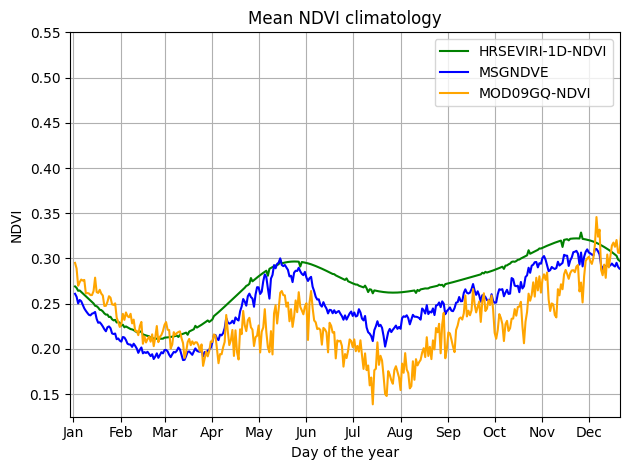

In [197]:
import matplotlib.dates as mdates

ds1.where(water_bodies==0).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="green", label="HRSEVIRI-1D-NDVI")
ds2.where(water_bodies==0).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="blue", label= "MSGNDVE")
ds3.where(water_bodies==0).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="orange", label="MOD09GQ-NDVI")

# Formatting x-axis ticks to show month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Abbreviated month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Get current x-axis limits
x_min, x_max = plt.xlim()

# Extend the x-axis limits to skip the last label
plt.xlim(x_min+15, x_max - 30)  # Skip the last 30 days
plt.ylim(0.125, 0.55)

plt.title('Mean NDVI climatology')
plt.legend()
plt.ylabel("NDVI")
plt.xlabel("Day of the year")
plt.grid(True)
plt.tight_layout()
plt.show()

### Droughts experiment

In [293]:
from vegetation import compute_vci

vci1 = compute_vci(ds1)
vci2 = compute_vci(ds2)
vci3 = compute_vci(ds3)

vci5 = compute_vci(ds5) 
vci6 = compute_vci(ds6.ndvi_10)
vci7 = compute_vci(ds7)

In [381]:
def check_vci(list_datasets, time_start=None, time_end=None, countries=None, regions=None):
    from utils.function_clns import subsetting_pipeline

    if countries is not None:
        temp_datasets = []
        for vci in list_datasets:
            temp_ds = subsetting_pipeline(vci, countries=countries, regions=regions)
            temp_datasets.append(temp_ds)

        list_datasets = temp_datasets.copy()

    for vci in list_datasets:
        if time_start is None:
            print(vci.mean().values)
        else:
            print(vci.sel(time= slice(time_start, time_end)).mean().values)


def plot_vci(datasets:list, 
            labels:list, 
            time_start:str=None, 
            time_end:str=None, 
            countries:list=None,
            regions:list=None,
            title:str=None,
            start_int:str=None,
            end_int:str=None):

    import matplotlib.dates as mdates
    from utils.function_clns import subsetting_pipeline

    new_datasets = []
    if countries is not None:
        for ds in datasets:
            ds = subsetting_pipeline(ds, countries=countries, regions=regions)
            new_datasets.append(ds)
    else:
        new_datasets = datasets.copy()
    
    for idx, ds in enumerate(new_datasets):
        temp_mean = ds.sel(time= slice(time_start, time_end)).mean(["lat","lon"])
        temp_mean.plot(label=labels[idx])
    
    # Formatting x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Adjust interval as needed

    # Rotate x-axis labels
    plt.xticks(rotation=45)

    # Add a light grey shade for a certain interval
    start_int = datetime.strptime(start_int, "%Y-%m-%d")  # Example start interval
    end_int = datetime.strptime(end_int, "%Y-%m-%d")    # Example end interval
    plt.axvspan(mdates.date2num(start_int), mdates.date2num(end_int), color='lightgrey', alpha=0.5)


    # Add annotations for drought start and end with arrows parallel to x-axis
    plt.annotate('Drought Start', xy=(start_int, plt.ylim()[1]),va='bottom', ha='center', xytext=(start_int, plt.ylim()[1]*0.9),
                 arrowprops=dict(facecolor='black', arrowstyle='->', mutation_scale=15))

    plt.annotate('Drought End', xy=(end_int, plt.ylim()[1]),va='bottom', ha='center', xytext=(end_int, plt.ylim()[1]*0.9),
                 arrowprops=dict(facecolor='black', arrowstyle='->', mutation_scale=15))


    plt.grid(True)

    plt.legend(loc='lower left')
    plt.ylabel("Vegetation Condition Index (VCI)")
    plt.xlabel("Date")

    plt.tight_layout()
    if title is not None:
        plt.title(title)
    plt.show()


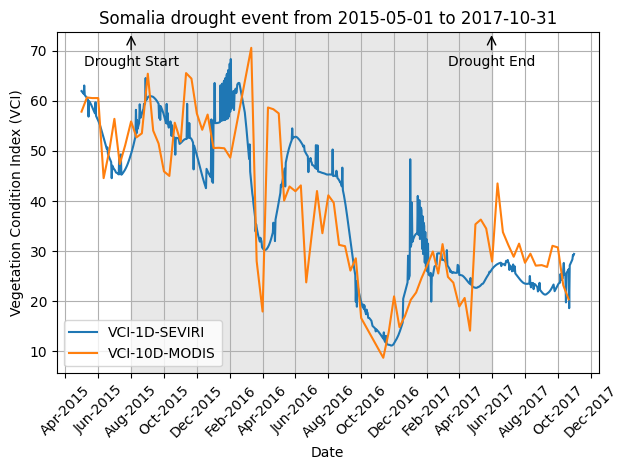

In [364]:
time_start = "2015-05-01"
start_int = "2015-08-01"
time_end = "2017-10-31"
end_int = "2017-05-31"

country = ["Somalia"]
labels = ["VCI-1D-SEVIRI", "VCI-10D-MODIS" ]

title = f"{country[0]} drought event from {time_start} to {time_end}"
# check_vci([vci1, vci2, vci6, vci7], time_start, time_end, country)
plot_vci([vci1, vci7], labels, time_start, time_end, country, title, start_int, end_int)

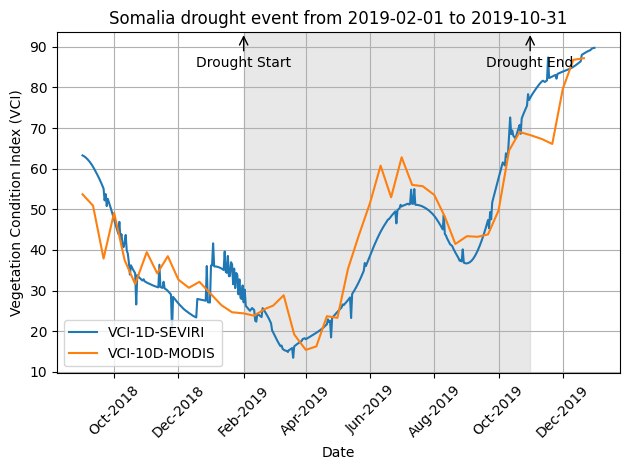

In [372]:
country = ["Somalia"]

start_int = "2019-02-01"
time_start = "2018-09-01"

end_int = "2019-10-31"
time_end = "2019-12-31"
labels = ["VCI-1D-SEVIRI", "VCI-10D-MODIS" ]

title = f"{country[0]} drought event from {start_int} to {end_int}"
# check_vci([vci1, vci2, vci6, vci7], time_start, time_end, country)
plot_vci([vci1, vci7], labels, time_start, time_end, country, title, start_int, end_int)

41.970688
46.229305
37.425083
43.21683


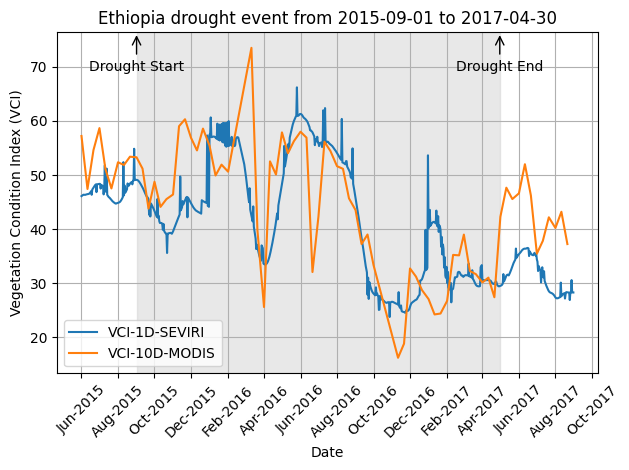

In [383]:
country = ["Ethiopia"]
start_int = "2015-09-01"
end_int = "2017-04-30"
time_start = "2015-06-01"
time_end = "2017-08-31"
regions = ["Somali", "Afar", "Oromia", "Amhara","SNNPR"]

labels = ["VCI-1D-SEVIRI", "VCI-10D-MODIS" ]
title = f"Ethiopia drought event from {start_int} to {end_int}"
check_vci([vci1, vci2, vci6, vci7], time_start=start_int, time_end=end_int, regions=regions)
plot_vci([vci1, vci7], labels=labels, time_start=time_start, 
    time_end=time_end, 
    regions=regions, title=title, 
    start_int=start_int, end_int=end_int)

39.817505
41.562626
40.535244
38.60469


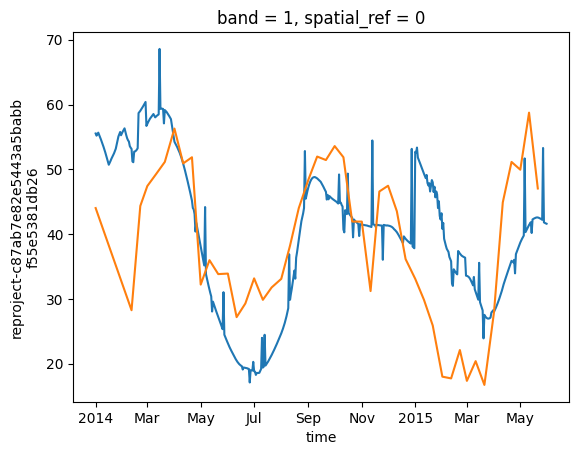

In [281]:
country = ["Kenya"]
time_start = "2014-01-01"
time_end = "2015-05-31"
check_vci([vci1, vci2, vci6, vci7], time_start, time_end, country)
plot_vci(vci1, time_start, time_end, country)
plot_vci(vci7, time_start, time_end, country)

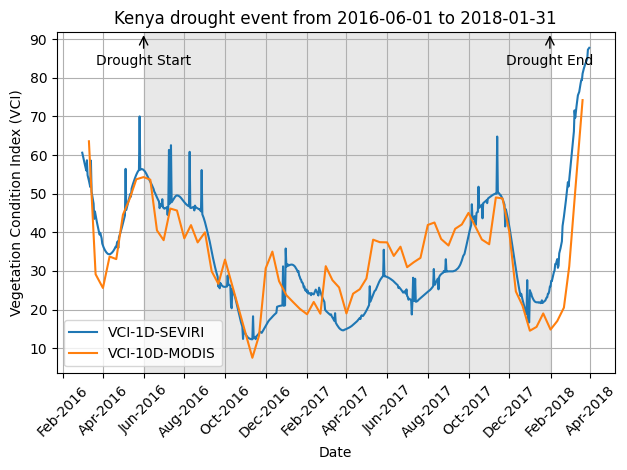

In [369]:
country = ["Kenya"]
start_int = "2016-06-01"
end_int = "2018-01-31"
time_start = "2016-03-01"
time_end = "2018-03-31"

labels = ["VCI-1D-SEVIRI", "VCI-10D-MODIS" ]
title = f"{country[0]} drought event from {start_int} to {end_int}"
# check_vci([vci1, vci2, vci6, vci7], time_start, time_end, country)
plot_vci([vci1, vci7], labels, time_start, time_end, country, title, start_int, end_int)

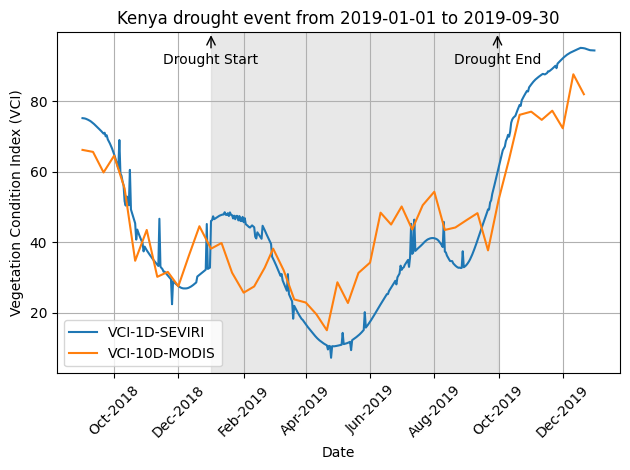

In [374]:
country = ["Kenya"]
start_int = "2019-01-01"
end_int = "2019-09-30"
time_start = "2018-09-01"
time_end = "2019-12-31"

labels = ["VCI-1D-SEVIRI", "VCI-10D-MODIS" ]
title = f"{country[0]} drought event from {start_int} to {end_int}"
# check_vci([vci1, vci2, vci6, vci7], time_start, time_end, country)
plot_vci([vci1, vci7], labels, time_start, time_end, country, title, start_int, end_int)

###  Wildfires experiment

1) Simen mountains Semien National Park was started on March 26, 2019

In [ ]:
events = [{"lat":10.32, "lon":39.8, "time_min": "2021-11-20", "time_max": "2021-12-20"}]

In [13]:
shap_path = os.path.join(config["SHAPE"]["base"], "shape-files/Kenya/KEN_adm4.shp")
from utils.function_clns import cut_file
import geopandas as gpd

gdf = gpd.read_file(shap_path)
column = "NAME_3"
gdf[gdf[column].str.contains("Kenya")]

column = "NAME_2"
location = "Mt. Kenya"
list_locations = ["Meru", "Nyeri","Embu", "Nithi","Kirinyaga"]
subset = gdf[gdf[column].isin(list_locations)]
mt_kenya = cut_file(ds_clean.ndvi, subset)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gdf.to_crs(gdf.crs).plot(ax=ax,legend=True, cmap="tab20c")
subset.plot(ax=ax, color="blue", alpha=0.5)

In [26]:
from vegetation.analysis.indices import compute_vci

vci = compute_vci(ds_ndvi)

with ProgressBar():
    vci = vci.load()

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


[########################################] | 100% Completed | 337.47 s


In [39]:
time_min = "2006-02-01"
time_max = "2006-03-20"

/media/BIFROST/N2/Riccardo/Indices_analysis/src/analysis/visualizations/viz_series.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


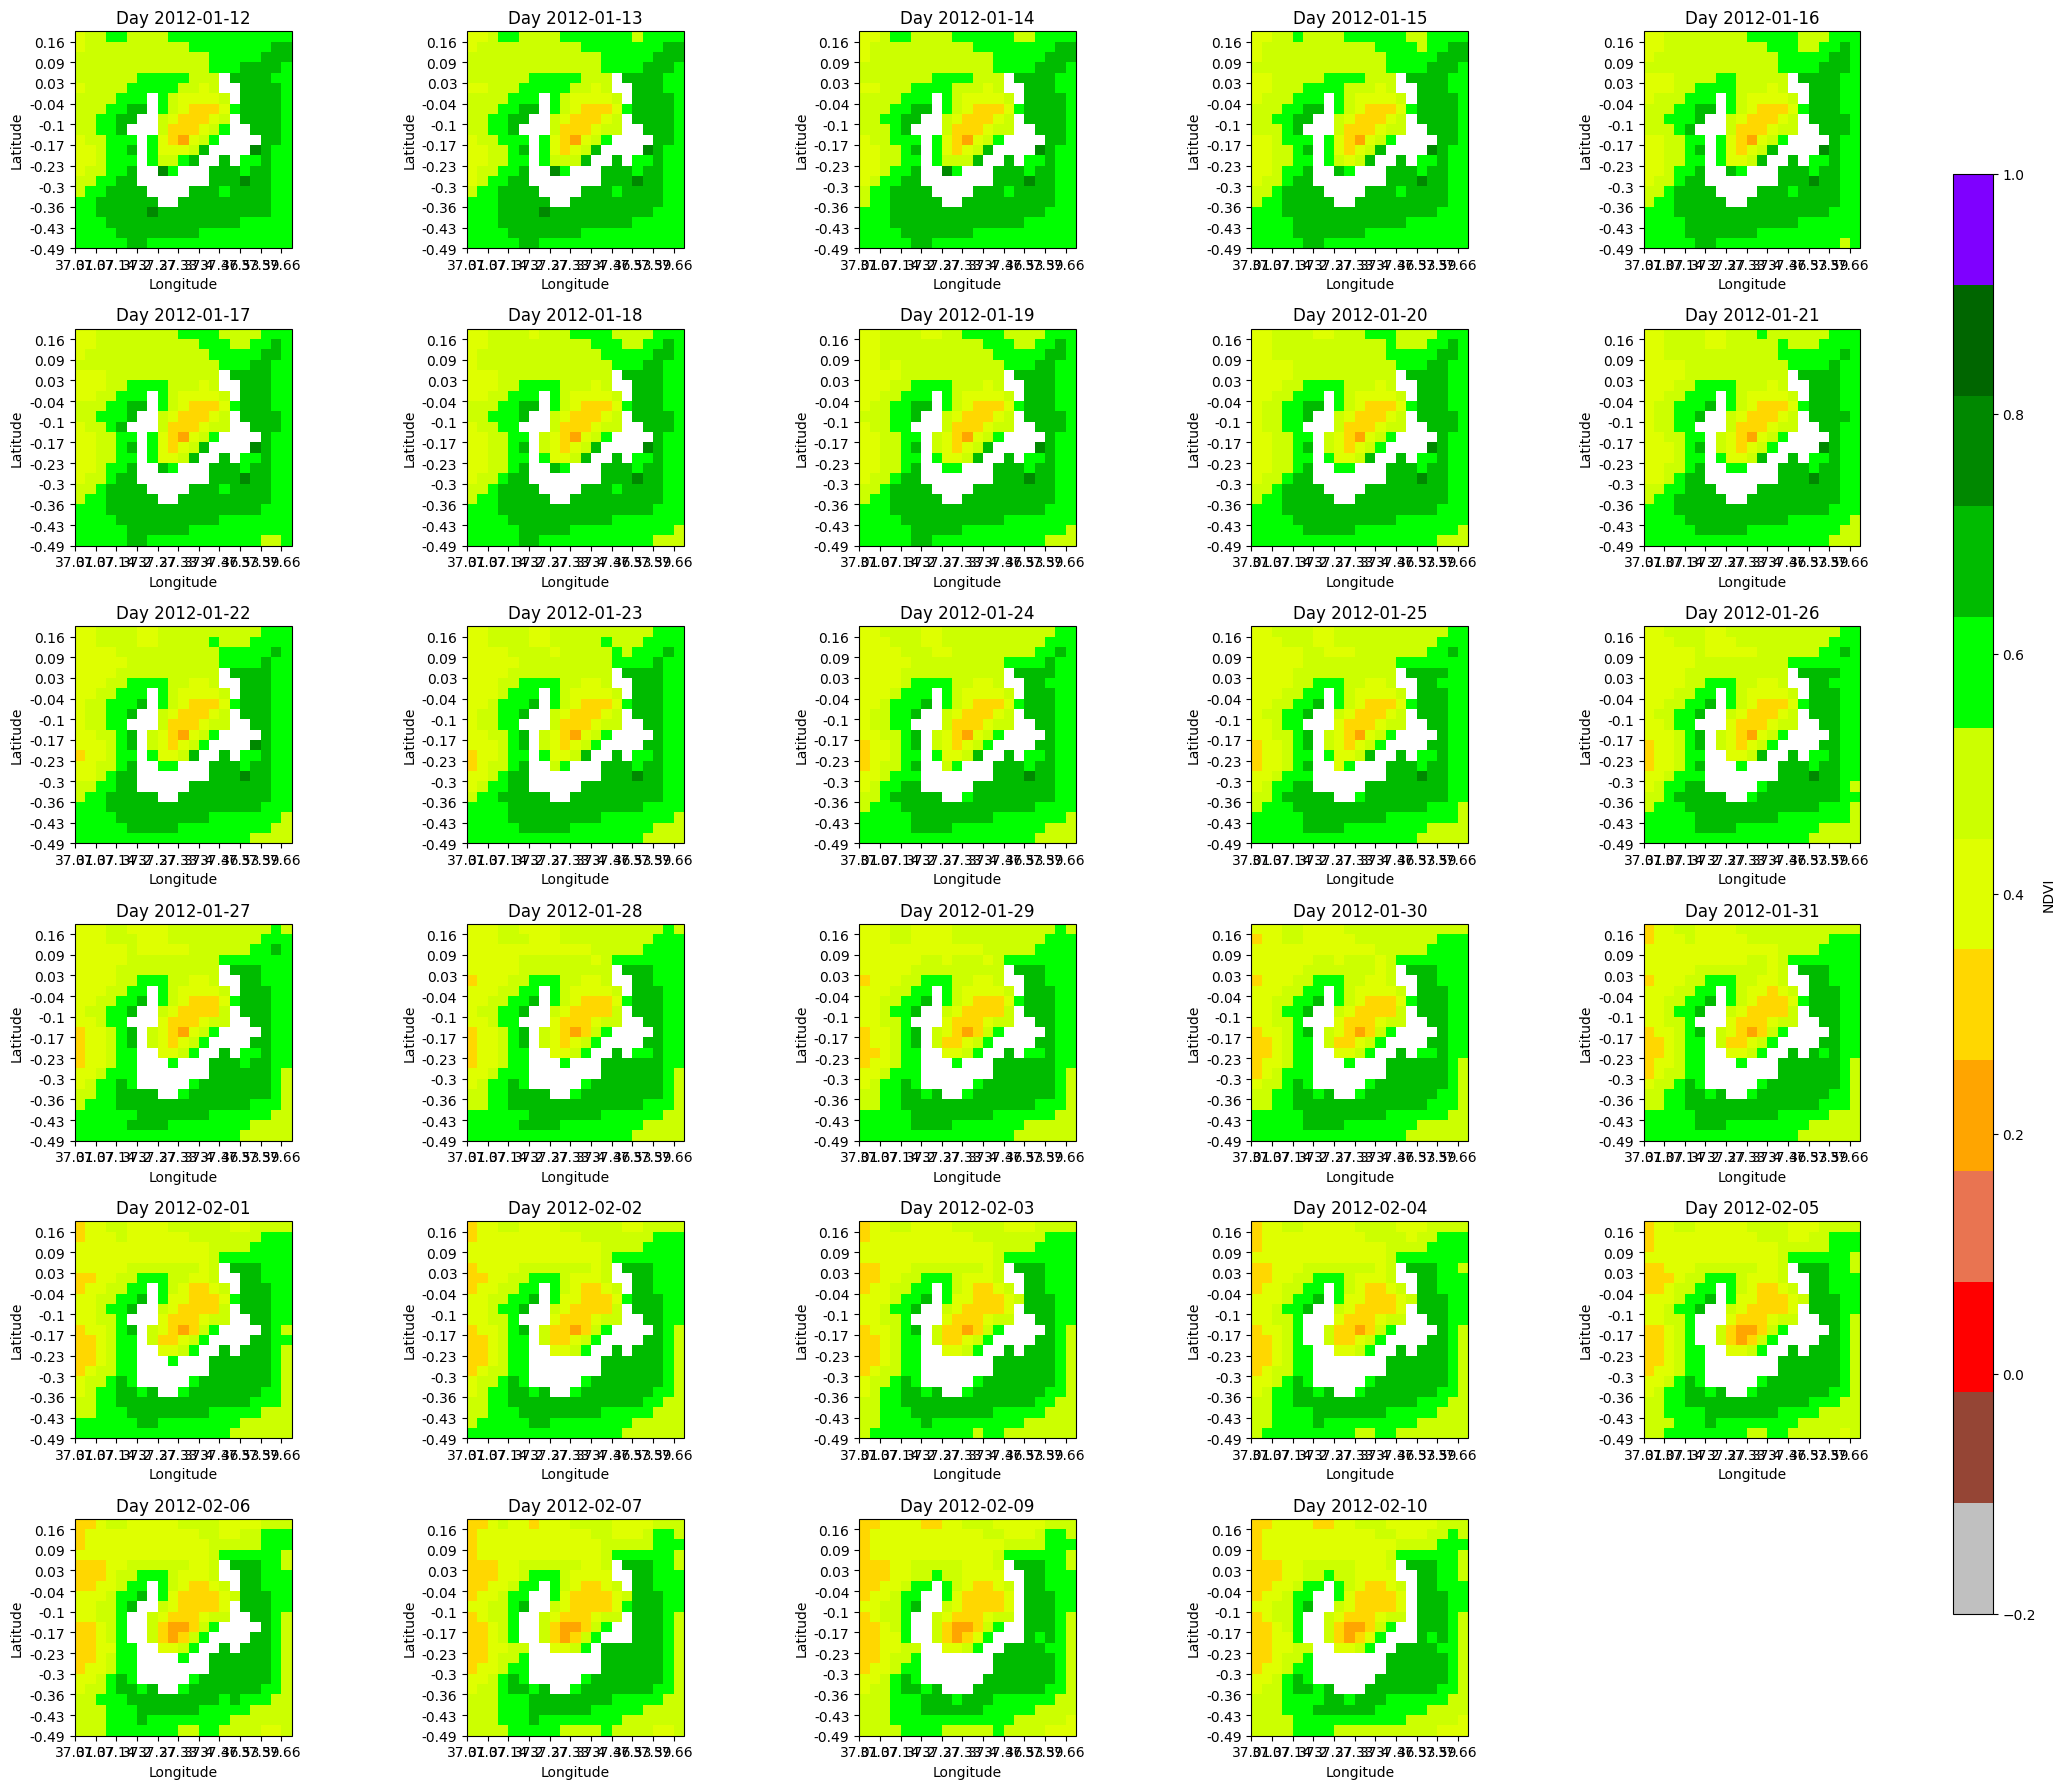

In [48]:
from analysis.visualizations.viz_series import plot_ndvi_days
import matplotlib.pyplot as plt

sub_area = ds_ndvi.sel(lat=slice(-0.5, 0.17 )).sel(lon=slice(37, 37.68))

time_min = "2012-01-12"
time_max = "2012-02-12"

cities = {
    "Timau": (0.05006, 37.14213),
    # "Nanyuki": (0.01667, 37.07283),
    #  "Chuka": (-0.33316, 37.64587),
    # "Kerugoya": (-0.49302, 37.26559),
    # "Meru": (0.053543, 37.648399),
    
}

# extra_area = 1.25

sub_ds = sub_area.sel(time=slice(time_min, time_max))
    #.sel(lat=slice(lat-extra_area, lat+extra_area))\
    # .sel(lon=slice(lon-extra_area, lon+extra_area)))

plot_ndvi_days(sub_ds, time_min, 30)

/media/BIFROST/N2/Riccardo/Indices_analysis/src/analysis/visualizations/viz_series.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


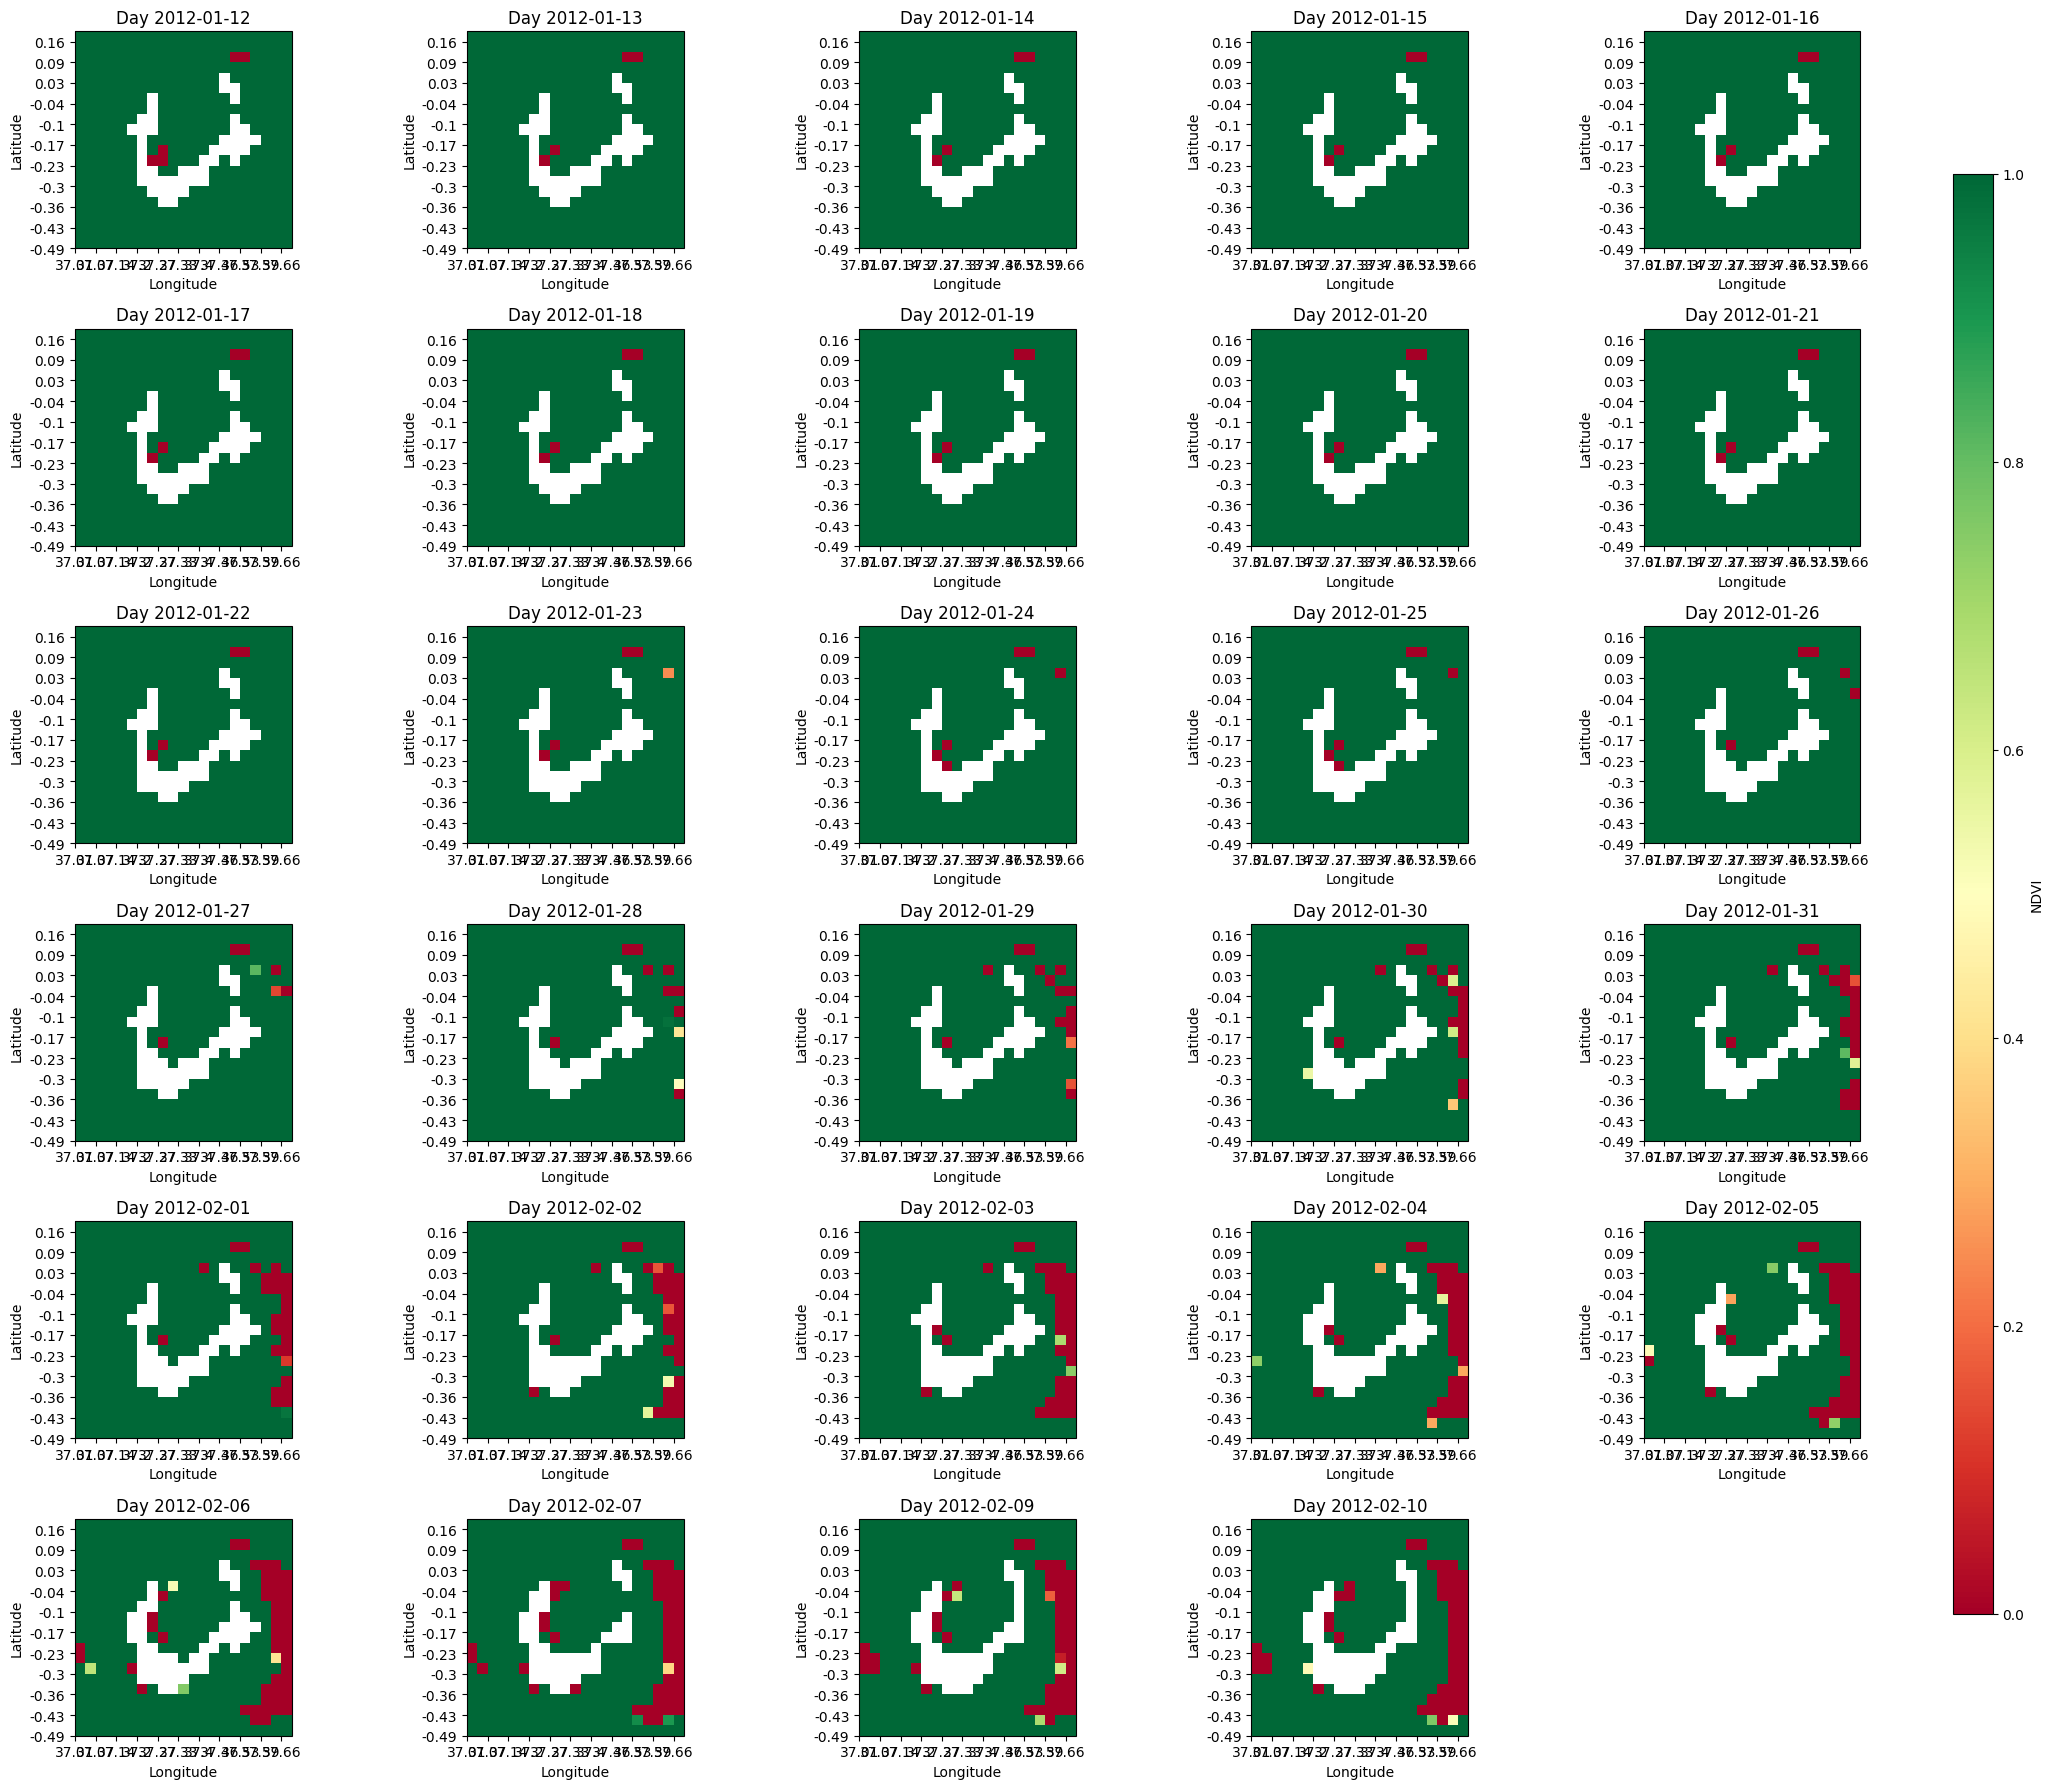

In [49]:
from analysis.visualizations.viz_series import plot_ndvi_days
import matplotlib.pyplot as plt
lat = 0.1521
lon = 37.3084

extra_area = 1.25

sub_ds = vci.where(sub_area<1).sel(time=slice(time_min, time_max))
    #.sel(lat=slice(lat-extra_area, lat+extra_area))\
    # .sel(lon=slice(lon-extra_area, lon+extra_area)))

plot_ndvi_days(sub_ds, time_min, 30, vmin=0, vmax=1, cmap="RdYlGn")